In [1]:
import plotly.io as pio
pio.renderers.default = "browser"


In [2]:
import pandas as pd

# Load the dataset
file_path = 'pollution_2000_2023.csv'
data = pd.read_csv(file_path)
# Display basic information about the dataset
data_info = {
    "Shape": data.shape,
    "Columns": data.columns.tolist(),
    "Missing Values": data.isnull().sum(),
    "Data Types": data.dtypes
}




In [3]:
# Step 1: Drop the unnecessary 'Unnamed: 0' column
data_cleaned = data.drop(columns=['Unnamed: 0'])

# Step 2: Convert 'Date' to datetime format
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'], errors='coerce')

# Step 3: Check and remove duplicates
initial_row_count = data_cleaned.shape[0]
data_cleaned = data_cleaned.drop_duplicates()
duplicates_removed = initial_row_count - data_cleaned.shape[0]

# Step 4: Describe numerical columns to identify potential outliers
numerical_summary = data_cleaned.describe()

# Output the results
{
    "Duplicates Removed": duplicates_removed,
    "Numerical Summary": numerical_summary
}


{'Duplicates Removed': 1739,
 'Numerical Summary':              O3 Mean  O3 1st Max Value  O3 1st Max Hour         O3 AQI  \
 count  663675.000000     663675.000000    663675.000000  663675.000000   
 mean        0.028605          0.038988        10.766949      39.149429   
 std         0.012157          0.014917         3.296334      22.265966   
 min        -0.000706          0.000000         7.000000       0.000000   
 25%         0.019824          0.029000         9.000000      27.000000   
 50%         0.028353          0.038000        10.000000      35.000000   
 75%         0.036882          0.048000        11.000000      44.000000   
 max         0.107353          0.140000        23.000000     237.000000   
 
              CO Mean  CO 1st Max Value  CO 1st Max Hour         CO AQI  \
 count  663675.000000     663675.000000    663675.000000  663675.000000   
 mean        0.329788          0.466171         5.929563       5.254192   
 std         0.275971          0.434902         

In [4]:
# Step 1: Replace negative values with NaN (non-physical values)
numerical_columns = [
    'O3 Mean', 'O3 1st Max Value', 'CO Mean', 'CO 1st Max Value',
    'SO2 Mean', 'SO2 1st Max Value', 'NO2 Mean', 'NO2 1st Max Value'
]
data_cleaned[numerical_columns] = data_cleaned[numerical_columns].applymap(
    lambda x: x if x >= 0 else None
)

# Step 2: Cap extreme outliers using the 99th percentile
for col in numerical_columns:
    upper_cap = data_cleaned[col].quantile(0.99)
    data_cleaned[col] = data_cleaned[col].clip(upper=upper_cap)

# Step 3: Recalculate summary statistics to verify changes
cleaned_summary = data_cleaned.describe()

cleaned_summary


,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
count,663673.000000,663675.000000,663675.000000,663675.000000,661736.000000,662726.000000,663675.000000,663675.000000,646303.000000,658913.000000,663675.000000,663675.000000,662748.000000,663510.000000,663675.000000,663675.000000
mean,0.028552,0.038899,10.766949,39.149429,0.326732,0.459680,5.929563,5.254192,1.432077,3.786787,8.865193,5.165726,11.470410,23.146106,11.588333,21.787970
std,0.012005,0.014625,3.296334,22.265966,0.249719,0.385799,7.720752,5.014410,2.118147,6.242061,6.775667,10.381727,8.666645,14.704091,7.888289,14.453261
min,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.019824,0.029000,9.000000,27.000000,0.179167,0.200000,0.000000,2.000000,0.200000,0.600000,3.000000,0.000000,4.876190,11.000000,5.000000,10.000000
50%,0.028353,0.038000,10.000000,35.000000,0.258333,0.300000,1.000000,3.000000,0.636364,1.400000,8.000000,1.000000,9.333333,21.000000,9.000000,20.000000
75%,0.036882,0.048000,11.000000,44.000000,0.412500,0.600000,9.000000,7.000000,1.666667,4.000000,13.000000,6.000000,16.000000,33.000000,20.000000,31.000000
max,0.058118,0.079000,23.000000,237.000000,1.370833,2.200000,23.000000,201.000000,11.791667,37.000000,23.000000,200.000000,40.304348,65.000000,23.000000,153.000000


In [5]:
# Step 1: Interpolate missing values for numerical columns
data_cleaned[numerical_columns] = data_cleaned[numerical_columns].interpolate(method='linear', limit_direction='forward')

# Step 2: Fill any remaining NaNs with column means
data_cleaned[numerical_columns] = data_cleaned[numerical_columns].fillna(data_cleaned[numerical_columns].mean())

# Verify there are no remaining missing values in numerical columns
missing_after_imputation = data_cleaned[numerical_columns].isnull().sum()

missing_after_imputation


O3 Mean              0
O3 1st Max Value     0
CO Mean              0
CO 1st Max Value     0
SO2 Mean             0
SO2 1st Max Value    0
NO2 Mean             0
NO2 1st Max Value    0
dtype: int64

In [6]:
# Step 1: Add lag features for pollutants (1-day lag)
for col in numerical_columns:
    data_cleaned[f"{col}_lag1"] = data_cleaned[col].shift(1)

# Step 2: Add pollutant ratios as derived features
data_cleaned['PM25_to_PM10_ratio'] = data_cleaned['O3 Mean'] / (data_cleaned['NO2 Mean'] + 1e-6)  # Avoid division by zero
data_cleaned['CO_to_SO2_ratio'] = data_cleaned['CO Mean'] / (data_cleaned['SO2 Mean'] + 1e-6)

# Step 3: Drop rows with NaNs introduced by lagging
data_cleaned = data_cleaned.dropna()

# Verify the newly created features
engineered_features_summary = data_cleaned[['O3 Mean_lag1', 'PM25_to_PM10_ratio', 'CO_to_SO2_ratio']].describe()

engineered_features_summary


,O3 Mean_lag1,PM25_to_PM10_ratio,CO_to_SO2_ratio
count,663674.000000,663674.000000,6.636740e+05
mean,0.028552,173.245595,1.661055e+04
std,0.012005,2530.786554,8.030019e+04
min,0.000000,0.000000,0.000000e+00
25%,0.019824,0.001473,1.730516e-01
50%,0.028353,0.003167,4.272064e-01
75%,0.036882,0.006545,1.245569e+00
max,0.058118,58118.000000,1.370833e+06


In [7]:
import pandas as pd

# Filter data for NYC
nyc_data = data_cleaned[data_cleaned['City'] == 'New York']

# Check for non-unique dates
if nyc_data['Date'].duplicated().any():
    # Group by date and calculate the mean for specified features
    nyc_data = (
        nyc_data.groupby('Date', as_index=False)
        .agg({
            'O3 Mean': 'mean',
            'CO Mean': 'mean',
            'SO2 Mean': 'mean',
            'NO2 Mean': 'mean',
        })
    )
#extend with col "Address" that is just "NYC Average"
nyc_data['Address'] = 'NYC Average'
# Split data into training, validation, and testing sets
training_data = nyc_data[nyc_data['Date'] < '2019-01-01']
validation_data = nyc_data[(nyc_data['Date'] >= '2019-01-01') & (nyc_data['Date'] < '2021-01-01')]
testing_data = nyc_data[nyc_data['Date'] >= '2021-01-01']

# Define features and target
features = [
    'O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean',
]
target = 'O3_Mean_Change'

# Ensure no non-unique values remain
assert nyc_data['Date'].duplicated().sum() == 0, "There are still non-unique dates in the dataset."
nyc_data

,Date,O3 Mean,CO Mean,SO2 Mean,NO2 Mean,Address
0,2000-01-01,0.001941,0.652632,11.791667,28.041667,NYC Average
1,2000-01-02,0.009588,0.833333,11.791667,35.375000,NYC Average
2,2000-01-03,0.004235,0.383333,9.958333,32.875000,NYC Average
3,2000-01-04,0.009588,0.150000,3.541667,22.125000,NYC Average
4,2000-01-05,0.016706,0.050000,3.291667,15.958333,NYC Average
...,...,...,...,...,...,...
8630,2023-08-27,0.035353,0.262500,0.125000,4.379167,NYC Average
8631,2023-08-28,0.026118,0.262500,0.104167,4.910526,NYC Average
8632,2023-08-29,0.026176,0.225000,0.100000,5.962500,NYC Average
8633,2023-08-30,0.036000,0.229167,0.112500,7.512500,NYC Average


In [8]:
def categorize_changes_in_mean(x):
    if x <= -0.30:
        return "(-inf,-30%]"
    elif x <= -0.20:
        return "(-30%,-20%]"
    elif x <= -0.10:
        return "(-20%,-10%]"
    elif x <= -0.0:
        return "(10%,0%]"
    elif x <= 0.10:
        return "(0%,10%]"
    elif x <= 0.20:
        return "(10%,20%]"
    elif x <= 0.30:
        return "(20%,30%]"
    else:
        return "(30%,inf]"

def featurize_time_series(df, col_name, lag_freq, num_trailing_periods, reduce_rows=True,categorize_changes=True):
    '''
    Function to create lagged features for a time series dataset
    df: Input DataFrame
    col_name: Name of the column to be lagged
    lag_freq: Frequency of the lag (e.g., '1w' for 1 week, '1m' for 1 month)
    num_trailing_periods: Number of trailing periods to be created
    reduce_rows: Whether to reduce rows by grouping based on the lag frequency

    '''
    CONTROL_FOR_COLUMN = 'Address' #might wanna make this []

    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values([CONTROL_FOR_COLUMN, 'Date'])

    # Create a new dataframe with only the required columns
    new_df = df[[CONTROL_FOR_COLUMN, 'Date', col_name]].copy()
    new_df = new_df.rename(columns={col_name: f'{col_name}_t'})
    if reduce_rows:
        if lag_freq == '1w':
            new_df = new_df.groupby([CONTROL_FOR_COLUMN, pd.Grouper(key='Date', freq='W-MON')]).first().reset_index()
        elif lag_freq == '1m':
            new_df = new_df.groupby([CONTROL_FOR_COLUMN, pd.Grouper(key='Date', freq='MS')]).first().reset_index()
        elif lag_freq == '1q':
            new_df = new_df.groupby([CONTROL_FOR_COLUMN, pd.Grouper(key='Date', freq='QS')]).first().reset_index()
        elif lag_freq == '1y':
            new_df = new_df.groupby([CONTROL_FOR_COLUMN, pd.Grouper(key='Date', freq='AS')]).first().reset_index()
    #create lagged features 
    for i in range(1, num_trailing_periods + 1):
        new_df[f'{col_name}_t_minus_{i}'] = new_df.groupby(CONTROL_FOR_COLUMN)[f'{col_name}_t'].shift(i)
    if categorize_changes:
        #replace _t with _change by comparing to _t_minus_1
        new_df[f'{col_name}_change'] = new_df[f'{col_name}_t'] / new_df[f'{col_name}_t_minus_1'] - 1
        new_df[f'{col_name}_change_category'] = new_df[f'{col_name}_change'].apply(categorize_changes_in_mean)
        #rename change category to _t_change
        new_df = new_df.drop(columns=[f'{col_name}_change'])
        # new_df = new_df.drop(columns=[f'{col_name}_t'])
        new_df = new_df.rename(columns={f'{col_name}_change_category': f'{col_name}_t_change'})

    new_df = new_df.dropna() #insufficient trailing periods
    return new_df    

FEATURIZATION_LAG_FREQ = '1d'
NUM_PERIODS = 14

featurized_dfs = {  }
for feature in features:
    featurized_dfs[feature] = featurize_time_series(nyc_data, feature, FEATURIZATION_LAG_FREQ, NUM_PERIODS)
#inner join all tables in featurized_dfs' values. Shared cols are Address and Date
featurized_data = featurized_dfs[features[0]]
for feature in features[1:]:
    featurized_data = featurized_data.merge(featurized_dfs[feature], on=['Address', 'Date'])
target_col_names = [f'{feature}_t_change' for feature in features]
feature_col_names = [col for col in featurized_data.columns if 't_minus' in col] #past data only
VIEW_ONLY_COL_NAMES = [f'{feature}_t' for feature in features]
#rearrange so the Address, Date, and target col names are upfront but do not lose any cols
reference_only_data = featurized_data[['Address','Date'] + VIEW_ONLY_COL_NAMES]
featurized_data = featurized_data[['Address', 'Date'] + target_col_names + feature_col_names]
featurized_data

,Address,Date,O3 Mean_t_change,CO Mean_t_change,SO2 Mean_t_change,NO2 Mean_t_change,O3 Mean_t_minus_1,O3 Mean_t_minus_2,O3 Mean_t_minus_3,O3 Mean_t_minus_4,...,NO2 Mean_t_minus_5,NO2 Mean_t_minus_6,NO2 Mean_t_minus_7,NO2 Mean_t_minus_8,NO2 Mean_t_minus_9,NO2 Mean_t_minus_10,NO2 Mean_t_minus_11,NO2 Mean_t_minus_12,NO2 Mean_t_minus_13,NO2 Mean_t_minus_14
0,NYC Average,2000-01-15,"(-inf,-30%]","(30%,inf]","(30%,inf]","(30%,inf]",0.022588,0.017353,0.002300,0.010412,...,28.250000,33.375000,25.500000,34.458333,31.125000,15.958333,22.125000,32.875000,35.375000,28.041667
1,NYC Average,2000-01-16,"(30%,inf]","(0%,10%]","(-inf,-30%]","(-inf,-30%]",0.008118,0.022588,0.017353,0.002300,...,28.333333,28.250000,33.375000,25.500000,34.458333,31.125000,15.958333,22.125000,32.875000,35.375000
2,NYC Average,2000-01-17,"(0%,10%]","(-inf,-30%]","(-inf,-30%]","(-30%,-20%]",0.020294,0.008118,0.022588,0.017353,...,23.909091,28.333333,28.250000,33.375000,25.500000,34.458333,31.125000,15.958333,22.125000,32.875000
3,NYC Average,2000-01-18,"(-inf,-30%]","(0%,10%]","(30%,inf]","(30%,inf]",0.021529,0.020294,0.008118,0.022588,...,22.208333,23.909091,28.333333,28.250000,33.375000,25.500000,34.458333,31.125000,15.958333,22.125000
4,NYC Average,2000-01-19,"(10%,0%]","(30%,inf]","(10%,0%]","(30%,inf]",0.008353,0.021529,0.020294,0.008118,...,13.958333,22.208333,23.909091,28.333333,28.250000,33.375000,25.500000,34.458333,31.125000,15.958333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8616,NYC Average,2023-08-27,"(10%,20%]","(-30%,-20%]","(-20%,-10%]","(-inf,-30%]",0.032118,0.019824,0.029176,0.035118,...,4.200000,14.508333,13.716667,4.816667,5.354167,4.129167,5.112500,6.389474,13.208333,6.833333
8617,NYC Average,2023-08-28,"(-30%,-20%]","(10%,0%]","(-20%,-10%]","(10%,20%]",0.035353,0.032118,0.019824,0.029176,...,4.308333,4.200000,14.508333,13.716667,4.816667,5.354167,4.129167,5.112500,6.389474,13.208333
8618,NYC Average,2023-08-29,"(0%,10%]","(-20%,-10%]","(10%,0%]","(20%,30%]",0.026118,0.035353,0.032118,0.019824,...,6.345455,4.308333,4.200000,14.508333,13.716667,4.816667,5.354167,4.129167,5.112500,6.389474
8619,NYC Average,2023-08-30,"(30%,inf]","(0%,10%]","(10%,20%]","(20%,30%]",0.026176,0.026118,0.035353,0.032118,...,7.883333,6.345455,4.308333,4.200000,14.508333,13.716667,4.816667,5.354167,4.129167,5.112500


In [9]:
#group O3_Mean_t_change by category to see how diverse the labels are 
featurized_data['O3 Mean_t_change'].value_counts(normalize=True)

(30%,inf]      0.266558
(-inf,-30%]    0.214592
(10%,0%]       0.103352
(-20%,-10%]    0.103236
(-30%,-20%]    0.090129
(0%,10%]       0.088157
(10%,20%]      0.074469
(20%,30%]      0.059506
Name: O3 Mean_t_change, dtype: float64

### The following target columns must be predicted using the below feature columns. 

In [10]:
print("Feature columns to use for training:", feature_col_names)
print("Target columns to predict:", target_col_names)

Feature columns to use for training: ['O3 Mean_t_minus_1', 'O3 Mean_t_minus_2', 'O3 Mean_t_minus_3', 'O3 Mean_t_minus_4', 'O3 Mean_t_minus_5', 'O3 Mean_t_minus_6', 'O3 Mean_t_minus_7', 'O3 Mean_t_minus_8', 'O3 Mean_t_minus_9', 'O3 Mean_t_minus_10', 'O3 Mean_t_minus_11', 'O3 Mean_t_minus_12', 'O3 Mean_t_minus_13', 'O3 Mean_t_minus_14', 'CO Mean_t_minus_1', 'CO Mean_t_minus_2', 'CO Mean_t_minus_3', 'CO Mean_t_minus_4', 'CO Mean_t_minus_5', 'CO Mean_t_minus_6', 'CO Mean_t_minus_7', 'CO Mean_t_minus_8', 'CO Mean_t_minus_9', 'CO Mean_t_minus_10', 'CO Mean_t_minus_11', 'CO Mean_t_minus_12', 'CO Mean_t_minus_13', 'CO Mean_t_minus_14', 'SO2 Mean_t_minus_1', 'SO2 Mean_t_minus_2', 'SO2 Mean_t_minus_3', 'SO2 Mean_t_minus_4', 'SO2 Mean_t_minus_5', 'SO2 Mean_t_minus_6', 'SO2 Mean_t_minus_7', 'SO2 Mean_t_minus_8', 'SO2 Mean_t_minus_9', 'SO2 Mean_t_minus_10', 'SO2 Mean_t_minus_11', 'SO2 Mean_t_minus_12', 'SO2 Mean_t_minus_13', 'SO2 Mean_t_minus_14', 'NO2 Mean_t_minus_1', 'NO2 Mean_t_minus_2', 'NO2 Me

Saved distribution plot for O3 Mean_t at results/eda_graphs/distribution_O3_Mean_t.png


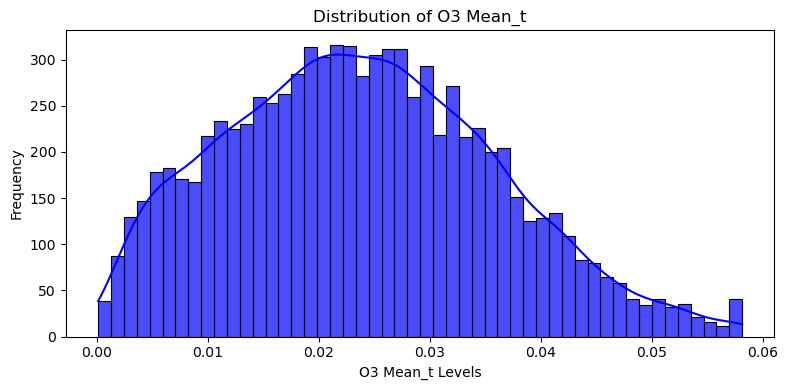

Saved distribution plot for CO Mean_t at results/eda_graphs/distribution_CO_Mean_t.png


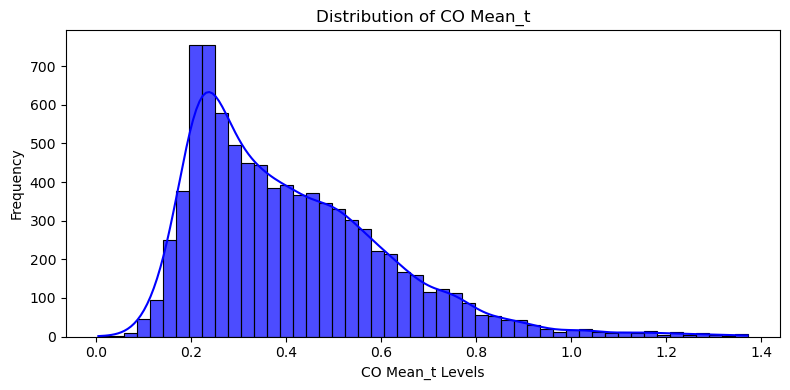

Saved distribution plot for SO2 Mean_t at results/eda_graphs/distribution_SO2_Mean_t.png


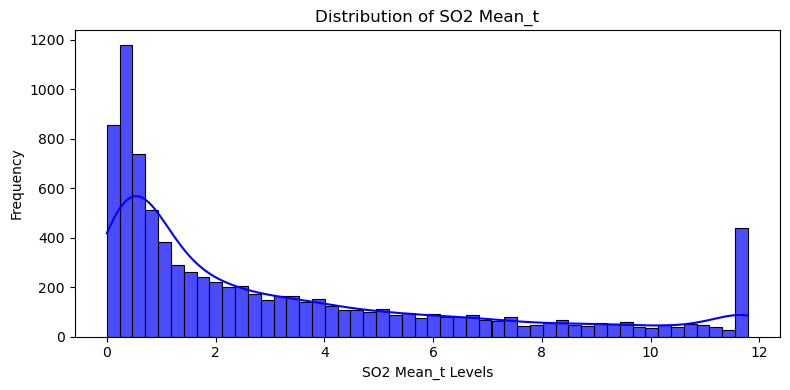

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Create a results folder for EDA graphs
eda_graphs_folder = "results/eda_graphs"
os.makedirs(eda_graphs_folder, exist_ok=True)

# Step 1: Exploratory Data Analysis (EDA)

# Define numerical features explicitly
# numerical_features = ['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']
VIEW_ONLY_COL_NAMES # 
# Visualize the distribution of key pollutants
for pollutant in VIEW_ONLY_COL_NAMES:
    plt.figure(figsize=(8, 4))
    sns.histplot(reference_only_data[pollutant], bins=50, kde=True, color="blue", alpha=0.7)
    plt.title(f"Distribution of {pollutant}")
    plt.xlabel(f"{pollutant} Levels")
    plt.ylabel("Frequency")
    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(eda_graphs_folder, f"distribution_{pollutant.replace(' ', '_')}.png")
    plt.savefig(plot_path)
    print(f"Saved distribution plot for {pollutant} at {plot_path}")

    # Show the plot
    plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
corr_matrix = reference_only_data[[f for f in VIEW_ONLY_COL_NAMES]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()

# Save the heatmap
heatmap_path = os.path.join(eda_graphs_folder, "correlation_heatmap.png")
plt.savefig(heatmap_path)
print(f"Saved correlation heatmap at {heatmap_path}")

# Show the heatmap
plt.show()

In [ ]:
featurized_data.min()

Address                        NYC Average
Date                   2000-01-15 00:00:00
O3 Mean_t_change               (-20%,-10%]
CO Mean_t_change               (-20%,-10%]
SO2 Mean_t_change              (-20%,-10%]
                              ...         
NO2 Mean_t_minus_10                 2.4625
NO2 Mean_t_minus_11                 2.4625
NO2 Mean_t_minus_12                 2.4625
NO2 Mean_t_minus_13                 2.4625
NO2 Mean_t_minus_14                 2.4625
Length: 62, dtype: object

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


## Preprocessing

In [ ]:
TRAINING_DATA_START_DATE = "2000-01-01"
VALIDATION_DATA_START_DATE = "2015-01-01"
TESTING_DATA_START_DATE = "2019-01-01"
#split is approx 60-20-20
# Split the data into training, validation, and testing sets
training_data   = featurized_data[featurized_data['Date'] >= TRAINING_DATA_START_DATE]
validation_data = featurized_data[(featurized_data['Date'] >= VALIDATION_DATA_START_DATE) & (featurized_data['Date'] < TESTING_DATA_START_DATE)]

training_and_validation_data = featurized_data[featurized_data['Date'] >= TRAINING_DATA_START_DATE]
testing_data    = featurized_data[featurized_data['Date'] >= TESTING_DATA_START_DATE]

X_train = training_data[feature_col_names]
X_val = validation_data[feature_col_names]

X_train_and_val = training_and_validation_data[feature_col_names]
X_test = testing_data[feature_col_names]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_and_val_scaled = scaler.transform(X_train_and_val)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.90)
X_train_reduced = pca.fit_transform(X_train_scaled).astype(np.float32)
X_val_reduced = pca.transform(X_val_scaled).astype(np.float32)
X_train_and_val = pca.transform(X_train_and_val_scaled).astype(np.float32)
X_test_reduced = pca.transform(X_test_scaled).astype(np.float32)

# Combine training and validation datasets for predefined split
X_combined = np.vstack([X_train_reduced, X_val_reduced])
test_fold = [-1] * len(X_train_reduced) + [0] * len(X_val_reduced)
predefined_split = PredefinedSplit(test_fold=test_fold)


In [ ]:
class ImprovedMLPModel(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes=(100, 50), dropout_rate=0.3):
        super(ImprovedMLPModel, self).__init__()
        layers = []
        for i, units in enumerate(hidden_layer_sizes):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_layer_sizes[i - 1], units))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(units))  # Add batch normalization
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_layer_sizes[-1], 1))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define Skorch wrapper for Improved MLP
def build_improved_skorch_mlp(hidden_layer_sizes=(100, 50), dropout_rate=0.3, lr=0.001):
    model = NeuralNetClassifier(
        module=ImprovedMLPModel,
        module__input_dim=X_train_reduced.shape[1],
        module__hidden_layer_sizes=hidden_layer_sizes,
        module__dropout_rate=dropout_rate,
        max_epochs=50,  # Train for more epochs
        lr=lr,
        optimizer=optim.Adam,
        optimizer__weight_decay=1e-5,  # Add L2 regularization
        criterion=nn.BCEWithLogitsLoss,
        train_split=None,
        verbose=0,
    )
    return model

# Updated model configurations
param_grids = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight="balanced"),
        "param_grid": {
            "n_estimators": [50, 100],
            "max_depth": [5, 10],
            "min_samples_split": [5, 10],
        },
    },
    "Logistic Regression (L1)": {
        "model": LogisticRegression(random_state=42, max_iter=5000, solver="liblinear"),
        "param_grid": {
            "C": [0.01, 0.1, 1],
            "penalty": ["l1"],  # L1 regularization
        },
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            "learning_rate": [0.01, 0.1],
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
        },
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [15, 18, 22],
            "weights": ["uniform"],
            "metric": ["minkowski", "euclidean"],
        },
    },
    "Improved MLP with Dropout": {
        "model": build_improved_skorch_mlp(),
        "param_grid": {
            "module__hidden_layer_sizes": [(100,), (100, 50)],
            "module__dropout_rate": [0.3, 0.5],
            "lr": [0.001, 0.01],
        },
    },
}



In [ ]:
# Create results folder
os.makedirs("results", exist_ok=True)

# Initialize results dictionary
results = {}
all_results = pd.DataFrame()

for target in target_col_names:
    target_folder = f"results/{target}"
    os.makedirs(target_folder, exist_ok=True)
    
    # Encode the target variable
    le = LabelEncoder()
    y_train = le.fit_transform(training_data[target]).astype(np.float32).reshape(-1, 1)
    y_val = le.transform(validation_data[target]).astype(np.float32).reshape(-1, 1)
    y_test = le.transform(testing_data[target]).astype(np.float32).reshape(-1, 1)

    # Flatten the labels for compatibility
    y_train_1d = y_train.ravel()
    y_val_1d = y_val.ravel()

    # Combine training and validation labels
    y_combined = np.hstack([y_train_1d, y_val_1d])

    results[target] = {}

    for model_name, config in param_grids.items():
        model_folder = f"{target_folder}/{model_name.replace(' ', '_')}"
        os.makedirs(model_folder, exist_ok=True)
        print(f"Tuning {model_name} for target {target}...")

        # Grid search with predefined split
        grid_search = GridSearchCV(
            estimator=config["model"],
            param_grid=config["param_grid"],
            scoring="accuracy",
            cv=predefined_split,
            return_train_score=True,
        )
        grid_search.fit(X_combined, y_combined if "Improved MLP" not in model_name else y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        # Save the best model to disk
        model_path = os.path.join(model_folder, "best_model.pkl")
        with open(model_path, "wb") as f:
            pickle.dump(best_model, f)
        print(f"Saved {model_name} for target {target} to {model_path}")

        # Training performance
        y_train_pred = best_model.predict(X_train_reduced)
        train_accuracy = accuracy_score(y_train_1d, y_train_pred)
        train_f1 = f1_score(y_train_1d, y_train_pred, average="weighted")

        # Validation performance
        y_val_pred = best_model.predict(X_val_reduced)
        val_accuracy = accuracy_score(y_val_1d, y_val_pred)
        val_f1 = f1_score(y_val_1d, y_val_pred, average="weighted")

        # Save metrics to all_results DataFrame
        new_row = pd.DataFrame([{
            "Target": target,
            "Model": model_name,
            "Best Params": best_params,
            "Train Accuracy": train_accuracy,
            "Train F1 Score": train_f1,
            "Validation Accuracy": val_accuracy,
            "Validation F1 Score": val_f1,
            "Best CV Accuracy": best_score,
        }])
        all_results = pd.concat([all_results, new_row], ignore_index=True)

        print(f"Best {model_name} Params: {best_params}")
        print(f"Train Accuracy: {train_accuracy:.2f}, Train F1 Score: {train_f1:.2f}")
        print(f"Validation Accuracy: {val_accuracy:.2f}, Validation F1 Score: {val_f1:.2f}\n")

# Save all results to CSV
all_results.to_csv("results/all_results.csv", index=False)
print("All results saved to 'results/all_results.csv'")

Tuning Random Forest for target O3 Mean_t_change...
Saved Random Forest for target O3 Mean_t_change to results/O3 Mean_t_change/Random_Forest/best_model.pkl
Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Train Accuracy: 0.86, Train F1 Score: 0.86
Validation Accuracy: 0.93, Validation F1 Score: 0.93

Tuning Logistic Regression (L1) for target O3 Mean_t_change...
Saved Logistic Regression (L1) for target O3 Mean_t_change to results/O3 Mean_t_change/Logistic_Regression_(L1)/best_model.pkl
Best Logistic Regression (L1) Params: {'C': 0.1, 'penalty': 'l1'}
Train Accuracy: 0.38, Train F1 Score: 0.27
Validation Accuracy: 0.35, Validation F1 Score: 0.25

Tuning Gradient Boosting for target O3 Mean_t_change...


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd
import os
import pickle
from sklearn.preprocessing import LabelEncoder

# Load results from the CSV file generated during training
results_df = pd.read_csv("results/all_results.csv")

# Debugging: Check the structure of results_df
print("Loaded results from CSV:")
print(results_df.head())

# Create a folder to store evaluation reports
evaluation_results_folder = "results/evaluation_reports"
os.makedirs(evaluation_results_folder, exist_ok=True)

# Iterate through the targets to evaluate the best model for each target
for target in results_df["Target"].unique():
    print(f"\nEvaluating the best model for target: {target}")

    # Filter results for the current target
    target_results = results_df[results_df["Target"] == target]

    if target_results.empty:
        print(f"No results available for target: {target}. Skipping evaluation.")
        continue

    # Identify the best model based on validation accuracy
    best_model_row = target_results.loc[target_results["Validation Accuracy"].idxmax()]
    best_model_name = best_model_row["Model"]
    best_params = best_model_row["Best Params"]
    print(f"The best model is: {best_model_name}")
    print(f"Best parameters: {best_params}")
    print(f"Validation Accuracy: {best_model_row['Validation Accuracy']:.2f}\n")

    # Load the trained best model for the current target
    model_folder = f"results/{target}/{best_model_name.replace(' ', '_')}"
    model_path = os.path.join(model_folder, "best_model.pkl")
    print(f"Looking for model file at: {model_path}")

    # Check if the model file exists
    if not os.path.exists(model_path):
        print(f"Trained model file not found for {best_model_name} and target {target}. Skipping.")
        continue

    # Load the model using pickle
    with open(model_path, "rb") as model_file:
        best_model = pickle.load(model_file)

    # Prepare the test dataset
    le = LabelEncoder()
    
    #TODO: WE MUST TRAIN ON THE TRAIN+VAL DATASET AND TEST ON THE TEST DATASET!! 

    le.fit(training_data[target])  # Fit LabelEncoder on training data
    y_test = le.transform(testing_data[target])  # Encode test target variable

    # Predict on the test dataset
    y_pred_test = best_model.predict(X_test_reduced)

    # Calculate evaluation metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average="weighted", zero_division=1)

    # Print evaluation details
    print(f"{best_model_name} (Tuned) Testing Evaluation:")
    print(f"  Testing Accuracy: {test_accuracy:.2f}")
    print(f"  Testing F1 Score: {test_f1:.2f}\n")

    # Generate the classification report
    classification_rep = classification_report(
        y_test, y_pred_test, zero_division=1, target_names=le.classes_
    )
    print("Classification Report:")
    print(classification_rep)

    # Save the evaluation results in a text file
    evaluation_file_path = os.path.join(evaluation_results_folder, f"{target}_evaluation.txt")
    with open(evaluation_file_path, "w") as f:
        f.write(f"The best model is: {best_model_name}\n")
        f.write(f"Best parameters: {best_params}\n")
        f.write(f"Validation Accuracy: {best_model_row['Validation Accuracy']:.2f}\n\n")
        f.write("Testing Results:\n")
        f.write(f"  Testing Accuracy: {test_accuracy:.2f}\n")
        f.write(f"  Testing F1 Score: {test_f1:.2f}\n\n")
        f.write("Classification Report:\n")
        f.write(classification_rep)
    print(f"Saved evaluation report to {evaluation_file_path}")

print("\nEvaluation completed for all targets.")

Loaded results from CSV:
             Target                      Model  \
0  O3 Mean_t_change              Random Forest   
1  O3 Mean_t_change   Logistic Regression (L1)   
2  O3 Mean_t_change          Gradient Boosting   
3  O3 Mean_t_change                        KNN   
4  O3 Mean_t_change  Improved MLP with Dropout   

                                         Best Params  Train Accuracy  \
0  {'max_depth': 10, 'min_samples_split': 5, 'n_e...        0.870194   
1                        {'C': 0.1, 'penalty': 'l1'}        0.393466   
2  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...        0.357473   
3  {'metric': 'minkowski', 'n_neighbors': 22, 'we...        0.387684   
4  {'lr': 0.001, 'module__dropout_rate': 0.3, 'mo...        0.089766   

   Train F1 Score  Validation Accuracy  Validation F1 Score  Best CV Accuracy  
0        0.868991             0.221918             0.224812          0.294449  
1        0.276007             0.309589             0.202926          0.375398  
2


Visualizing performance for target: O3 Mean_t_change
Saved graph for O3 Mean_t_change at: results/O3 Mean_t_change/graphs/validation_performance.png


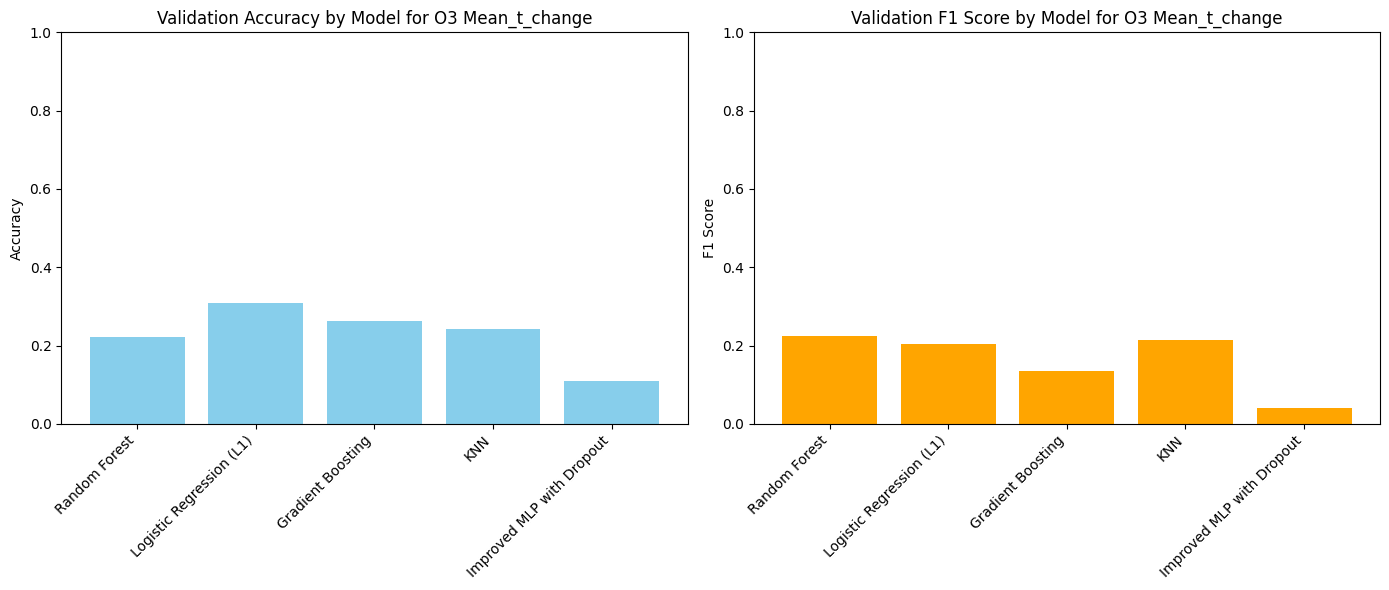


Visualizing performance for target: CO Mean_t_change
Saved graph for CO Mean_t_change at: results/CO Mean_t_change/graphs/validation_performance.png


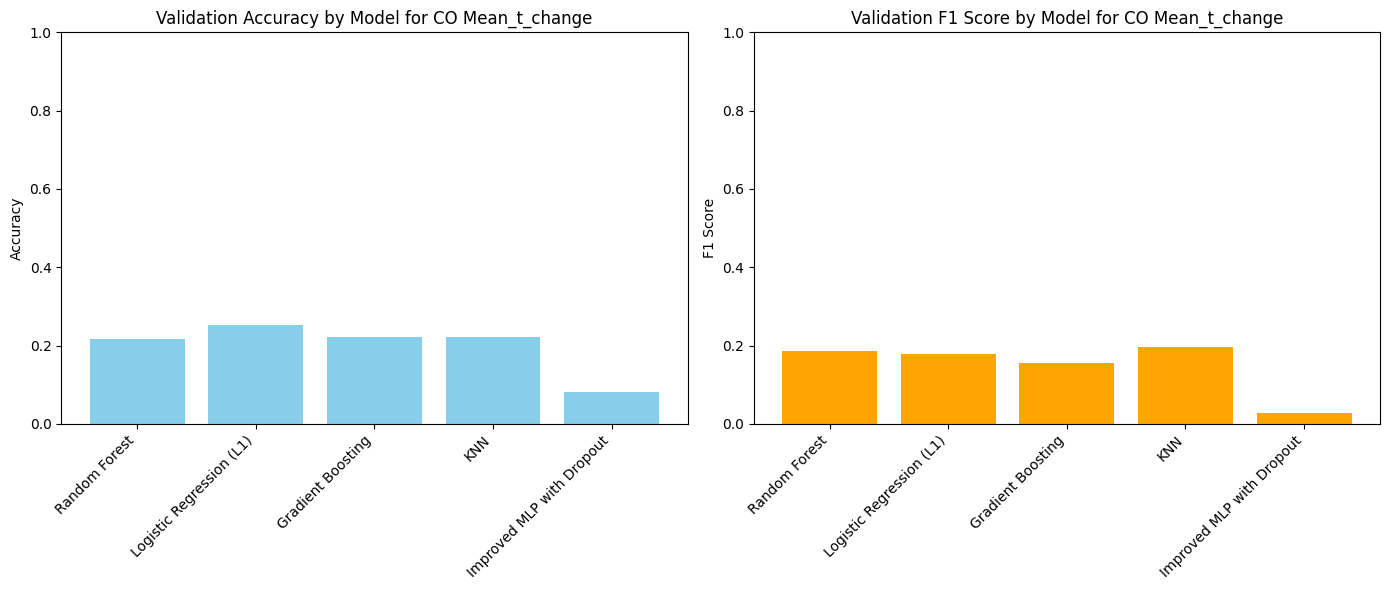


Visualizing performance for target: SO2 Mean_t_change
Saved graph for SO2 Mean_t_change at: results/SO2 Mean_t_change/graphs/validation_performance.png


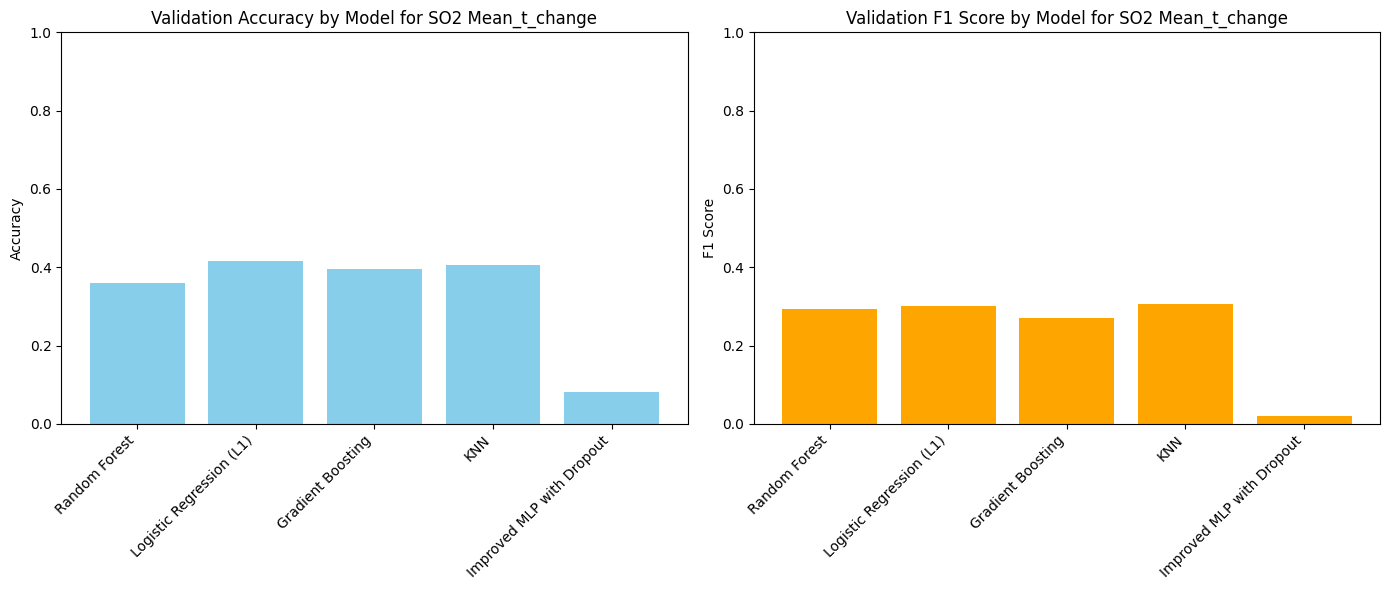


Visualizing performance for target: NO2 Mean_t_change
Saved graph for NO2 Mean_t_change at: results/NO2 Mean_t_change/graphs/validation_performance.png


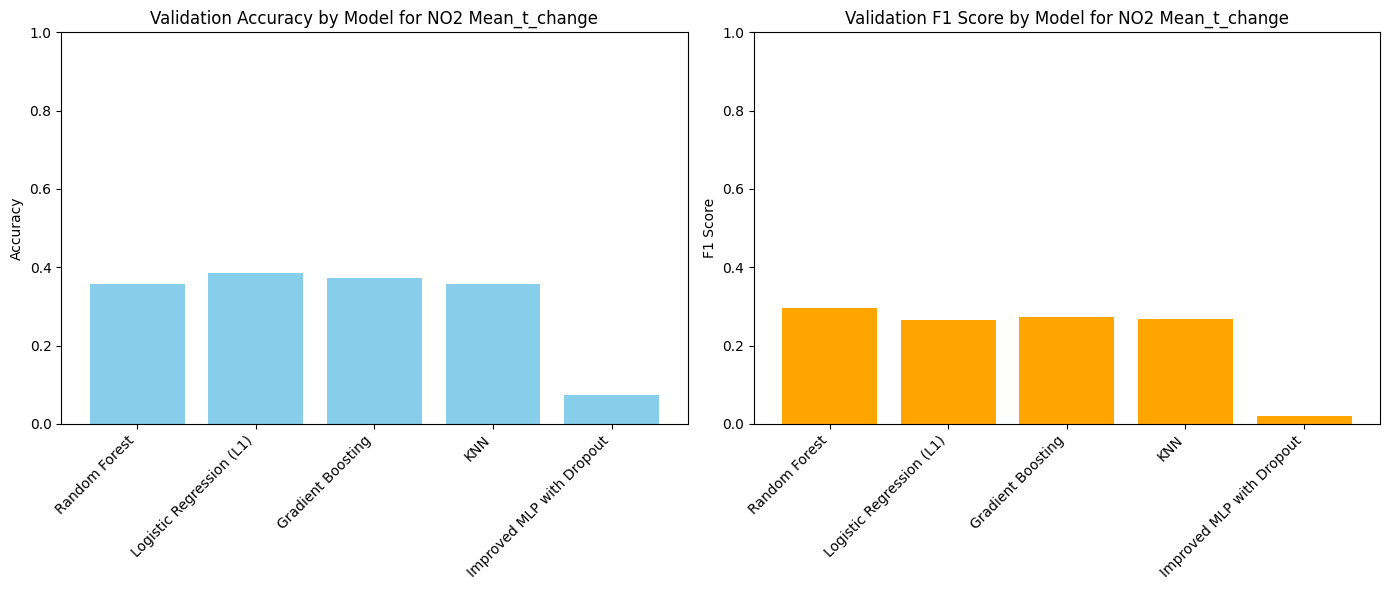

In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np

# Ensure validation data is reduced with PCA
X_val_reduced = pca.transform(X_val_scaled).astype(np.float32)

# Load results from the CSV file generated earlier
results_df = pd.read_csv("results/all_results.csv")

# Iterate over targets to visualize and save performance
for target in results_df["Target"].unique():
    print(f"\nVisualizing performance for target: {target}")
    
    # Create a folder for graphs specific to the target
    target_graph_folder = f"results/{target}/graphs"
    os.makedirs(target_graph_folder, exist_ok=True)
    
    # Extract data for the current target
    target_results = results_df[results_df["Target"] == target]
    if target_results.empty:
        print(f"No results available for target: {target}. Skipping visualization.")
        continue
    
    model_names = target_results["Model"].tolist()
    accuracies = target_results["Validation Accuracy"].tolist()
    f1_scores = target_results["Validation F1 Score"].tolist()
    
    # Plot Accuracy and F1 Score
    plt.figure(figsize=(14, 6))

    # Accuracy Bar Chart
    plt.subplot(1, 2, 1)
    plt.bar(model_names, accuracies, color="skyblue")
    plt.title(f"Validation Accuracy by Model for {target}")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability

    # F1 Score Bar Chart
    plt.subplot(1, 2, 2)
    plt.bar(model_names, f1_scores, color="orange")
    plt.title(f"Validation F1 Score by Model for {target}")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability

    plt.tight_layout()

    # Save the plot
    graph_path = f"{target_graph_folder}/validation_performance.png"
    plt.savefig(graph_path)
    print(f"Saved graph for {target} at: {graph_path}")

    # Show the graph
    plt.show()

In [ ]:
import plotly.express as px
import plotly.io as pio

# Ensure the correct renderer is set for JupyterLab
pio.renderers.default = "jupyterlab"

# List of features to plot (e.g., pollutant levels or other target columns)
features_to_plot = VIEW_ONLY_COL_NAMES  # Replace with any list of columns to plot

# Plot trends over time for each feature
for feature in features_to_plot:
    fig = px.line(
        reference_only_data,  # Replace with the appropriate DataFrame
        x="Date",
        y=feature,
        title=f"{feature} Trends Over Time",
        labels={"Date": "Date", feature: "Value"}
    )
    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Value",
        template="plotly_white"
    )
    fig.show()


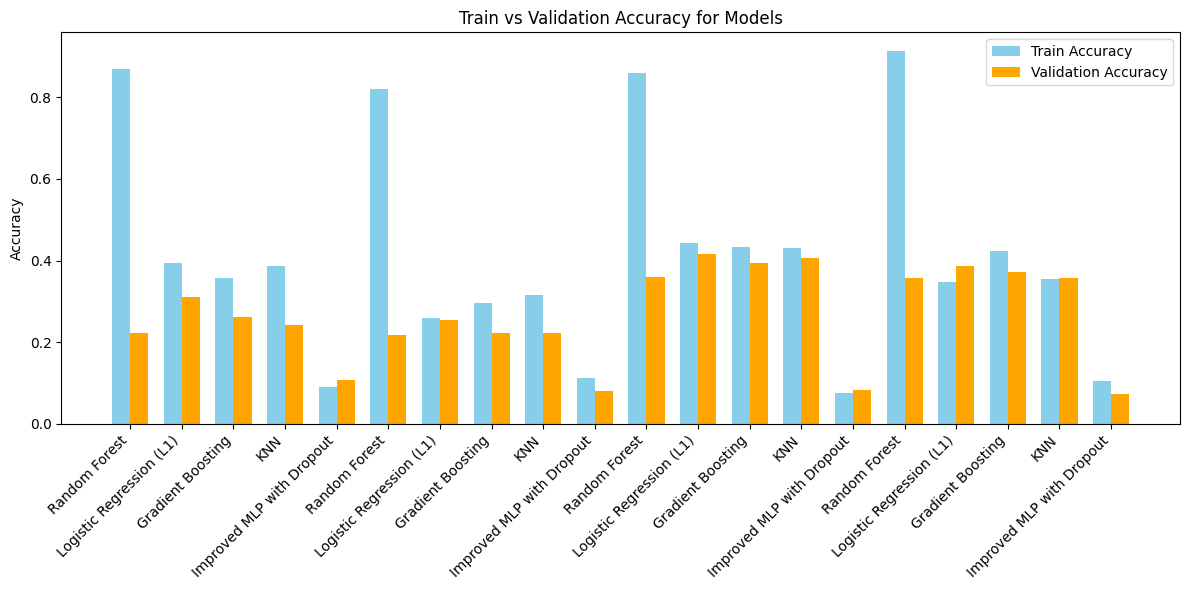

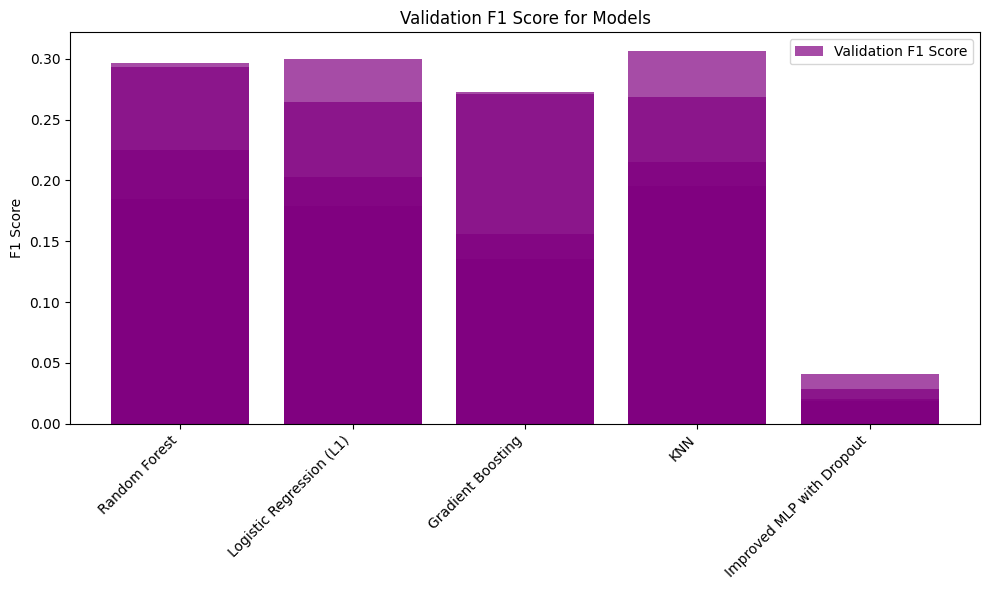

In [ ]:
# Extract relevant data for visualization
models = results_df["Model"]
train_accuracy = results_df["Train Accuracy"]
validation_accuracy = results_df["Validation Accuracy"]
validation_f1_score = results_df["Validation F1 Score"]

# 1. Bar Chart for Train vs Validation Accuracy
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index - bar_width / 2, train_accuracy, bar_width, label="Train Accuracy", color="skyblue")
plt.bar(index + bar_width / 2, validation_accuracy, bar_width, label="Validation Accuracy", color="orange")
plt.xticks(index, models, rotation=45, ha="right")
plt.title("Train vs Validation Accuracy for Models")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Bar Chart for Validation F1 Score
plt.figure(figsize=(10, 6))
plt.bar(models, validation_f1_score, color="purple", alpha=0.7, label="Validation F1 Score")
plt.title("Validation F1 Score for Models")
plt.ylabel("F1 Score")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()